# Aplicando t-SNE al dataset de Iris

In [10]:
import pandas as pd
import numpy as np

import torch
import math

import plotly.express as px
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

## Cargando dataset de iris

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
iris_data = iris['data']
iris_class = iris['target']

iris = np.concatenate([iris_data, np.array([iris_class]).T], axis=1)

In [3]:
pd.DataFrame(iris)

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


## Puntos en dimensión ${\rm I\!R^2}$

In [4]:
n_muestras = iris.shape[0]

points2D = np.random.uniform(0, 10, size=(n_muestras, 2))

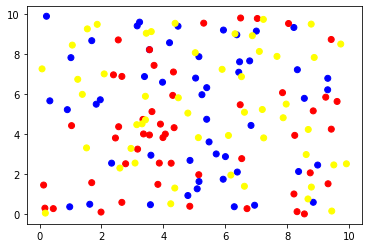

In [5]:
import matplotlib.pyplot as plt

color = ["blue" for _ in range(n_muestras//3)]
color.extend(["red" for _ in range(n_muestras//3)])
color.extend(["yellow" for _ in range(n_muestras//3)])

plt.scatter(points2D[:,0], points2D[:,1], color=color)

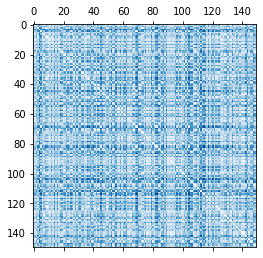

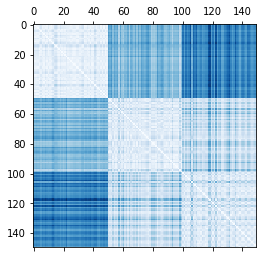

In [6]:
mat_2D = np.zeros((n_muestras,n_muestras))
mat_3D = np.zeros((n_muestras,n_muestras))

def distance(p1,p2):
    return np.sqrt(np.sum((p1 - p2)**2))

for i,p in enumerate(points2D):
    mat_2D[i] = [distance(p,j) for j in points2D]
    
for i,q in enumerate(iris_data):
    mat_3D[i] = [distance(q,j) for j in iris_data]
      
plt.matshow(mat_2D, cmap=plt.cm.Blues)  # Representamos la matriz P
plt.matshow(mat_3D, cmap=plt.cm.Blues)  # Representamos la matriz Q

## Implementación t-SNE

In [7]:
device = 'cpu'

distT_torch = torch.distributions.studentT.StudentT(df=1, loc=0, scale=1)

def distance(p1,p2):
    return torch.sqrt(torch.sum((p1 - p2)**2) + 1e-6)
    
def pdf(x):
    return torch.exp(distT_torch.log_prob(x))

def KL(p, q):
    return torch.where(q > 0.1e-8, p * torch.log(p/q), torch.tensor([0.], dtype=torch.double, device=device)).sum()


In [8]:
class TSNE(torch.nn.Module):
    
    def __init__(self, Q_points, P_points, lr=0.1, device='cpu'):
        super().__init__()
        self.Q_points = Q_points
        self.P_points = P_points
        
        self.device = device
        self.P = torch.tensor(P_points, requires_grad=True, dtype=torch.float, device=device)
        self.Q = torch.tensor(Q_points, dtype=torch.float, device=device)
        
        self.optimizer = torch.optim.RMSprop([self.P], lr=lr)
    
    def get_p_points(self):
        return self.P.cpu().detach().numpy()
    
    def forward(self):
        PM = torch.tensor(np.zeros((len(self.P_points), len(self.P_points))), dtype=float, device=self.device)
        QM = torch.tensor(np.zeros((len(self.P_points), len(self.P_points))), dtype=float, device=self.device)
        
        for i, q_row in enumerate(self.Q):
            for j, q_column in enumerate(self.Q):
                QM[i,j] = distance(q_row, q_column)

        QD = pdf(QM)
        QD = torch.div(QD.t(), torch.sum(QD, dim=1)).t()

        for i, p_row in enumerate(self.P):
            for j, p_column in enumerate(self.P):
                PM[i,j] = distance(p_row, p_column)

        PD = pdf(PM)
        PD = torch.div(PD.t(), torch.sum(PD, dim=1)).t()
        
        loss = torch.tensor([0.], device=self.device)
        for pd, qd in zip(PD, QD):
            loss += KL(pd, qd)
        
        loss.backward()   
        self.optimizer.step()    
        self.optimizer.zero_grad()
        
        return loss


In [11]:

tsne = TSNE(iris_data, points2D)

epochs = 90

t = tqdm(range(epochs), desc='Loss', leave=True)
for c in t:
    
    loss = tsne()
    
    t.set_description("Loss {}".format(loss))
    t.refresh()


### Resultados

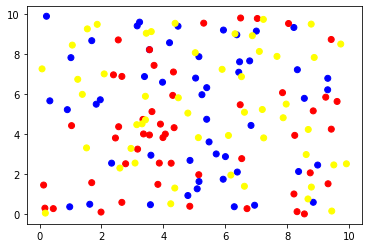

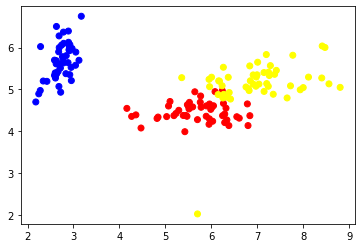

In [12]:
import matplotlib.pyplot as plt

final_points = tsne.get_p_points()
color = ["blue" for _ in range(n_muestras//3)]
color.extend(["red" for _ in range(n_muestras//3)])
color.extend(["yellow" for _ in range(n_muestras//3)])

plt.scatter(points2D[:,0], points2D[:,1], color=color)
plt.show()

plt.scatter(final_points[:,0], final_points[:,1], color=color)